# Example for fermionic system that maps to a spin system

In [1]:
from openfermion import QubitOperator, reverse_jordan_wigner, normal_ordered

# XXZ model
jx = 1/2
jy = 1/2
jz = -1/4
h = 1/2
qu_op = QubitOperator()
for i in range(8):
    qu_op += jx*QubitOperator(f"X{i} X{(i+1)}")
    qu_op += jy*QubitOperator(f"Y{i} Y{(i+1)}")
    qu_op += jz*QubitOperator(f"Z{i} Z{(i+1)}")
    qu_op += h*QubitOperator(f"Z{i}")

#print(qu_op)
print(normal_ordered(reverse_jordan_wigner(qu_op)))
#print(reverse_jordan_wigner(qu_op))


2.0 [] +
-0.5 [0^ 0] +
(1+0j) [0^ 1] +
(1+0j) [1^ 0] +
1.0 [1^ 0^ 1 0] +
(1+0j) [1^ 2] +
(1+0j) [2^ 1] +
1.0 [2^ 1^ 2 1] +
(1+0j) [2^ 3] +
(1+0j) [3^ 2] +
1.0 [3^ 2^ 3 2] +
(1+0j) [3^ 4] +
(1+0j) [4^ 3] +
1.0 [4^ 3^ 4 3] +
(1+0j) [4^ 5] +
(1+0j) [5^ 4] +
1.0 [5^ 4^ 5 4] +
(1+0j) [5^ 6] +
(1+0j) [6^ 5] +
1.0 [6^ 5^ 6 5] +
(1+0j) [6^ 7] +
(1+0j) [7^ 6] +
1.0 [7^ 6^ 7 6] +
(1+0j) [7^ 8] +
(1+0j) [8^ 7] +
1.0 [8^ 7^ 8 7] +
0.5 [8^ 8]


In [2]:
import TDDFTinversion as td
import numpy as np
import itertools

np1=16 #number of grid points for 1-dimension
#initialize systemparameters derived type
sysparams=td.derivedtypes.init_systemparameters(np1)
sysparams.nd=1 #number of dimensions
sysparams.npart=4 #number of particles
sysparams.nalpha=4
sysparams.nbeta=0
sysparams.xmin=0 #minimum grid point
sysparams.xmax=15 #maximum grid point
sysparams.ct=0. #starting time
sysparams.dth=0.01 #goal time step
sysparams.dvksmax=100 #max derivative of density with respect to time
sysparams.pinv0minresqlp1=1 #pseudoinverse set to 0, minresqlp set to 1
sysparams.quantization=2 #Quantization
sysparams.energy=-2 #Energy of KS system, this can if desired
td.derivedtypes.fill_systemparameters(sysparams)
td.keomod.buildkeo(sysparams) #build kinetic energy operator and lattice values
#print(sysparams)

n_pts_s = sysparams.np1//2

#generate derived type to store 1 and 2 body potentials
sharedvals=td.derivedtypes.init_sharedvalues(sysparams) #shared values derived type

# Transfer matrix (i^ i+1 + i+1^ i)
t1 = np.diag(np.ones(n_pts_s-1), 1)+np.diag(np.ones(n_pts_s-1), -1)
t1 = np.array(t1)
sysparams.t = np.kron(np.eye(2), t1)


# External potential for terms at 0^ 0 and 7^ 7
v1 = np.zeros(n_pts_s)
v1[0] = -0.5
v1[7] = 0.5
sharedvals.v1 = np.kron([1,0], v1)+np.kron([0,1], v1)

sharedvals.vinteract[:] = 0
for i, j in itertools.product(range(2*n_pts_s), repeat=2):
    if j%n_pts_s == i%n_pts_s + 1 or j%n_pts_s == i%n_pts_s -1:
        sharedvals.vinteract[j+i*2*n_pts_s] = 1

# If using alpha and beta spin system
#sharedvals.vinteract[0+7*sysparams.np1] = 1
#sharedvals.vinteract[7+0*sysparams.np1] = 1
#sharedvals.vinteract[0+8*sysparams.np1] = 1
#sharedvals.vinteract[8+0*sysparams.np1] = 1
#sharedvals.vinteract[0+15*sysparams.np1] = 1
#sharedvals.vinteract[15+0*sysparams.np1] = 1
#sharedvals.vinteract[8+15*sysparams.np1] = 1
#sharedvals.vinteract[15+8*sysparams.np1] = 1
#generate potentials, can write own program
#td.potential.generate_1bodypot(sysparams,sharedvals)
#td.potential.generate_2bodypot(sysparams,sharedvals)

#derived type that stores full wavefunction and potential
fullvals=td.derivedtypes.init_fullvalues(sysparams)
td.potential.generate_nbodypot(sysparams,sharedvals,fullvals)
td.initial_states.initializefullsystem(sysparams,fullvals)

#next 5 are required to develop and advance KS orbitals
dpe=np.zeros(sysparams.ntot1,dtype=np.float64) #current density
dnx=np.zeros(sysparams.ntot1,dtype=np.float64) #current derivative of density
ddnx=np.zeros(sysparams.ntot1,dtype=np.float64) #second derivative of density
dpenew=np.zeros(sysparams.ntot1,dtype=np.float64) #density after time step dt, taken from sysparams.dt
ddnxnew=np.zeros(sysparams.ntot1,dtype=np.float64) #second derivative of density after time step sysparams.dt

#placeholder for advancing full system
psinew=np.zeros(sysparams.ntot,dtype=np.complex128)

td.secondquant_wrap.calc_ground_state(sysparams, sharedvals, sysparams.np1, 40, fullvals.psi)
#print(fullvals.psi)
#print(np.linalg.norm(fullvals.psi))

td.density.fullwf_density(sysparams,fullvals.psi,dpe)

#initialize KS orbitals system to match dpe
#KSvals=td.initial_states.initializekssystem(sysparams,sharedvals,dpe,fullvals)





 eig  -4.0903591791722391       -3.2056636323121763       -2.4252974583725022       -2.3111841286562766       -1.8318917761149638     


In [3]:
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt
from scipy.optimize import minimize

Calculate 1rdm for KS system initialization

In [4]:
one_rdm_full = np.zeros((sysparams.np1, sysparams.np1), dtype=np.complex128, order="F")
td.secondquant_wrap.onerdm(sysparams, sysparams.np1, fullvals.psi, one_rdm_full)

In [5]:
rdm1 = np.zeros((n_pts_s, n_pts_s), dtype=np.float64, order="F")
import itertools
for i, j in itertools.product(range(sysparams.np1), repeat=2):
    rdm1[i%n_pts_s, j%n_pts_s] += one_rdm_full[i, j].real

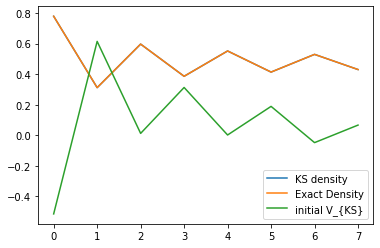

In [6]:

goal_d = np.diag(one_rdm_full.real)
#print(sum(goal_d))

# Method to initialize KS orbitals to match ground state 1RDM from 	arXiv:2008.05592
def func(vp, t, rdm):
    first_part = np.trace(np.matmul(t + np.diag(vp/np.sqrt(np.diag(rdm))), rdm))
    e, phi = eigsh(t + np.diag(vp/np.sqrt(np.diag(rdm))), k=4, which='SA')
    return first_part - e[0]-e[1]-e[2]-e[3]
def jac(vp, t, rdm):
    jacvals = np.zeros(len(vp))
    e, phi = eigsh(t + np.diag(vp/np.sqrt(np.diag(rdm))), k=4, which='SA')
    for i, v in enumerate(vp):
        jacvals[i] = rdm[i,i]/np.sqrt(rdm[i,i])
        jacvals[i] -= (phi[i,0]**2+phi[i,1]**2+phi[i,2]**2+phi[i,3]**2)/np.sqrt(rdm[i,i])
    return jacvals
vpar = np.sin(np.pi*sysparams.xlattice[:n_pts_s])*np.sqrt(np.diag(one_rdm_full[:n_pts_s, :n_pts_s].real))
result = minimize(func, vpar, args=(sysparams.t[:n_pts_s, 0:n_pts_s], one_rdm_full[:n_pts_s, :n_pts_s].real), jac=jac, method="L-BFGS-B", tol=1.e-14, options={"disp": False, "maxiter": 1000, "gtol": 1e-9})
#print(result)
#print(vpar)
#pl.plot(dvrpts_s, result.x/np.sqrt(np.diag(one_rdm))-vpot_harm(dvrpts_s, 1))


e, phi = eigsh(sysparams.t[:n_pts_s, :n_pts_s].real + np.diag(result.x/np.sqrt(np.diag(one_rdm_full[:n_pts_s, :n_pts_s].real))), k=4, which="SA")

ksdens = (phi[:,0]*phi[:,0]+phi[:,1]*phi[:,1]+phi[:,2]*phi[:,2]+phi[:,3]*phi[:,3]).flatten().real
init_vks = result.x/np.sqrt(np.diag(one_rdm_full[:n_pts_s].real))
plt.plot(sysparams.xlattice[:n_pts_s], ksdens.real, sysparams.xlattice[:n_pts_s], goal_d[:n_pts_s].real, sysparams.xlattice[:n_pts_s], init_vks)

plt.legend(['KS density', 'Exact Density', 'initial V_{KS}'])
#print(sum((2*(phi[:,0]**2)+1*(phi[:,1]**2)).flatten().real))

In [7]:
#initialize KS orbitals system to match dpe
KSvals=td.initial_states.initializekssystem(sysparams,sharedvals,dpe,fullvals)
o = np.array([1, 0])
z = np.array([0, 1])
KSvals.phi[:, 0] = np.kron(o, phi[:, 0])
KSvals.phi[:, 1] = np.kron(o, phi[:, 1])
KSvals.phi[:, 2] = np.kron(o, phi[:, 2])
KSvals.phi[:, 3] = np.kron(o, phi[:, 3])
KSvals.vks[:] = np.kron(o, result.x/np.sqrt(np.diag(one_rdm_full[:n_pts_s, :n_pts_s].real)))
sharedvals.vin[:] = sharedvals.v1[:]

 Calculating initial corresponding KS state


(0.0, 7.0)

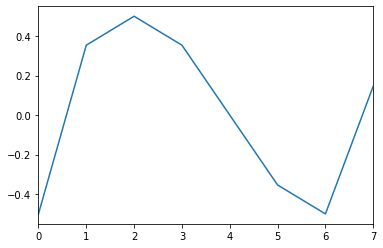

In [8]:
# Add sinusoidal potential to external potential (represented as sigma_z terms)
qu_op = QubitOperator()
for i in range(7):
    qu_op += QubitOperator(f"Z{i}", 0.5*np.sin(i*np.pi/4))
fe_op = reverse_jordan_wigner(qu_op)

vadd = np.zeros(n_pts_s)
for term, coeff in fe_op.terms.items():
    if term:
        vadd[term[0][0]] = coeff
    else:
        vadd += coeff

sharedvals.vin[:] += np.kron(o, 0.5*np.sin(np.array(range(n_pts_s))*np.pi/4))
sharedvals.v1[:] = sharedvals.vin[:]
plt.plot(sharedvals.vin)
plt.xlim([0, 7])

In [ ]:
sysparams.dt=sysparams.dth

for loop in range(1000):
    print('\n')
    print('For time '+str(sysparams.ct)+' to ',str(sysparams.ct+sysparams.dt))
    
    # generate wavefunction at ct+dt
    td.propagate.advancewf(sysparams,sharedvals,25,fullvals.v,fullvals.psi,psinew)
    
    #Calculate density, first derivative of density and second derivative of density 
    #at time ct using psi
    td.density.fullwf_density(sysparams,fullvals.psi,dpe)

    td.density.calcdnx(sysparams,sharedvals,sysparams.ntot1,fullvals.psi,fullvals.v,dnx)
    td.density.calcddnx(sysparams,sharedvals,sysparams.ntot1,fullvals.psi,fullvals.v,ddnx)
    
    #Calculate density and second derivative of density at time ct+dt using psinew
    td.density.fullwf_density(sysparams,psinew,dpenew)
    td.density.calcddnx(sysparams,sharedvals,sysparams.ntot1,psinew,fullvals.v,ddnxnew)
    
    #Attempt to advance KS system
    info=td.propagate.advancekssystem(dpe,dpenew,dnx,ddnx,ddnxnew,sysparams,KSvals,sharedvals)

    
    if (info==1):#succesful advance of orbitals shift full wavefunction
        fullvals.psi=psinew

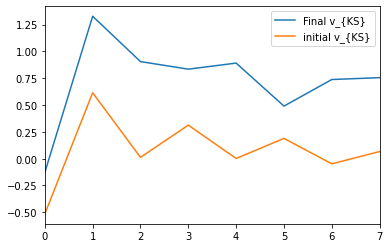

In [10]:
plt.plot(sysparams.xlattice, KSvals.vks, sysparams.xlattice[:n_pts_s], init_vks)
plt.xlim([0, 7])
plt.legend(["Final v_{KS}", "initial v_{KS}"])

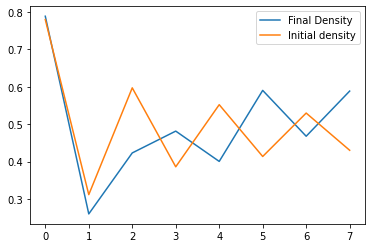

In [11]:
plt.plot(sysparams.xlattice[:n_pts_s], dpe[:n_pts_s], sysparams.xlattice[:n_pts_s], goal_d[:n_pts_s])
plt.legend(["Final Density", "Initial density"])